In [1]:
from math import ceil
from tqdm.notebook import tqdm
from pyspark.sql import SparkSession
import pyspark.sql.functions as f
from pyspark.sql.types import (
    StructType, StructField, StringType, DateType
)
from pyspark.ml import Pipeline
from pyspark.ml.feature import (
    CountVectorizer, RegexTokenizer,
    IDF, StopWordsRemover
)
from pyspark.ml.clustering import LDA
#Spark NLP
from sparknlp.annotator import *
from sparknlp.base import *
# plotting
from matplotlib import pyplot as plt
from wordcloud import WordCloud

In [2]:
spark = SparkSession.builder \
                    .appName("TopicModelTest") \
                    .config("spark.jars.packages",
                            "com.johnsnowlabs.nlp:spark-nlp_2.11:2.4.0") \
                    .getOrCreate()
sc = spark.sparkContext

In [3]:
params = dict(
    num_topics = 15,
    iterations = 10,
    vocabsize = 5000,
    minDF = 0.02,
    maxDF = 0.8
 )
params

{'num_topics': 15,
 'iterations': 10,
 'vocabsize': 5000,
 'minDF': 0.02,
 'maxDF': 0.8}

In [4]:
# Schema for input Data
schema = StructType([
    StructField("date", DateType(), True),
    StructField("headline", StringType(), True),
    StructField("content", StringType(), True)])
# Input file and Stopwords
inputfile = "../../data/nytimes.tsv"
stopwordfile = "../stopwords/custom_stopwords.txt"

In [5]:
def read_data(inputfile):
    """Read in a tab-separated file with date, headline and news content
       to a Spark DataFrame
    """
    df = (spark.read.option("header", "false")
          .csv(inputfile, sep='\t', schema=schema)
          .toDF("date", "headline", "content")
          .drop("headline"))
    return df.limit(2000)

In [6]:
df = read_data(inputfile)
df.show(5)

+----------+--------------------+
|      date|             content|
+----------+--------------------+
|2016-06-30|Stellar pitching ...|
|2016-06-30|Mayor Bill de Bla...|
|2016-06-30|In the early morn...|
|2016-06-30|It was the Apple ...|
|2016-06-30|The United States...|
+----------+--------------------+
only showing top 5 rows



### Spark preproc pipeline


In [7]:
def set_regextokenizer(inputCol, outputCol):
    "Use Spark to perform custom Regex tokenization"
    tokenizer = RegexTokenizer(
        inputCol=inputCol,
        outputCol=outputCol,
        pattern=r"[A-Za-z0-9\-]{3,50}",  # only alphanumeric hyphenated text with 3 or more chars
        gaps=False
    )
    return tokenizer


def set_stopword_remover(stopword, inputCol, outputCol):
    "use Spark to drop stopwords from a sequence of tokens"
    stopwords = sc.textFile(stopwordfile).collect()
    remover = (StopWordsRemover(
        inputCol=inputCol, outputCol=outputCol).setStopWords(stopwords))
    return remover

In [8]:
def run_spark_preproc_pipeline(df):
    """Create a Spark preprocessing that transforms the input DataFrame to produce a
       final output column storing each document as a list of tokens with stopwords removed.
    """
    preprocPipeline = Pipeline(stages=[
        set_regextokenizer("content", "words"),
        set_stopword_remover(stopwordfile, "words", "words_filtered")
    ])
    wordsDF = preprocPipeline.fit(df).transform(df)
    # Concatenate list of words into a single word for downstream Spark-NLP pipeline
    preprocDF = wordsDF.withColumn("words_joined", f.concat_ws(" ", "words_filtered"))
    return preprocDF

preprocDF = run_spark_preproc_pipeline(df)
preprocDF.show(5)

+----------+--------------------+--------------------+--------------------+--------------------+
|      date|             content|               words|      words_filtered|        words_joined|
+----------+--------------------+--------------------+--------------------+--------------------+
|2016-06-30|Stellar pitching ...|[stellar, pitchin...|[stellar, pitchin...|stellar pitching ...|
|2016-06-30|Mayor Bill de Bla...|[mayor, bill, bla...|[mayor, bill, bla...|mayor bill blasio...|
|2016-06-30|In the early morn...|[the, early, morn...|[early, morning, ...|early morning hou...|
|2016-06-30|It was the Apple ...|[was, the, apple,...|[apple, store, ne...|apple store new y...|
|2016-06-30|The United States...|[the, united, sta...|[united, states, ...|united states oly...|
+----------+--------------------+--------------------+--------------------+--------------------+
only showing top 5 rows



### Spark NLP pipeline

In [9]:
def set_document_assembler(inputCol):
    "Spark NLP document assembler"
    return DocumentAssembler().setInputCol(inputCol)


def set_tokenizer(inputCol, outputCol):
    "Tokenize text for input to the lemmatizer"
    tokenizer = (Tokenizer()
        .setInputCols([inputCol])
        .setOutputCol(outputCol)
    )
    return tokenizer


def set_lemmatizer(inputCol, outputCol):
    "Retrieve root lemmas out of the input tokens"
    # Use default SparkNLP English pretrained lemmatizer for now
    lemmatizer = (LemmatizerModel.pretrained(name="lemma_antbnc", lang="en")
        .setInputCols([inputCol])
        .setOutputCol(outputCol)
    )
    return lemmatizer


def set_finisher(finishedCol):
    "Finisher transform for Spark NLP pipeline"
    finisher = (Finisher()
        .setInputCols([finishedCol])
        .setIncludeMetadata(False)
    )
    return finisher


def run_sparknlp_pipeline(df):
    """Create a SparkNLP pipeline that transforms the input DataFrame to procude a final output
       column storing each document as a sequence of lemmas (root words).
    """
    nlpPipeline = Pipeline(stages=[
        set_document_assembler("words_joined"),
        set_tokenizer("document", "token"),
        set_lemmatizer("token", "lemma"),
        set_finisher("lemma")
    ])
    nlpPipelineDF = (nlpPipeline.fit(df)
        .transform(df)
        .withColumnRenamed('finished_lemma', 'allTokens')
    )
    return nlpPipelineDF

In [10]:
nlpPipelineDF = run_sparknlp_pipeline(preprocDF)
nlpPipelineDF.select('allTokens').show(5)

lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]
+--------------------+
|           allTokens|
+--------------------+
|[stellar, pitch, ...|
|[mayor, bill, bla...|
|[early, morning, ...|
|[apple, store, ne...|
|[united, state, o...|
+--------------------+
only showing top 5 rows



In [11]:
nlpPipelineDF.persist()

DataFrame[date: date, content: string, words: array<string>, words_filtered: array<string>, words_joined: string, allTokens: array<string>]

### Spark ML Pipeline

In [12]:
def set_countvectorizer(inputCol, outputCol, params):
    countvectorizer = CountVectorizer(
        inputCol=inputCol,
        outputCol=outputCol,
        vocabSize=params['vocabsize'],
        minDF=params['minDF'],
        maxDF=params['maxDF'],
        minTF=1.0
    )
    return countvectorizer


def set_idf(inputCol, outputCol):
    return IDF(inputCol="features", outputCol="idf")


def set_lda_model(params):
    lda = LDA(
        k=params['num_topics'],
        maxIter=params['iterations'],
        optimizer="online",
        seed=1,
        learningOffset=100.0,  # If high, early iterations are downweighted during training
        learningDecay=0.51,    # Set between [0.5, 1) to guarantee asymptotic convergence
    )
    return lda


def run_ml_pipeline(nlpPipelineDF, params):
    """Create a Spark ML pipeline and transform the input NLP-transformed DataFrame 
       to produce a trained LDA topic model for the given data.
    """
    mlPipeline = Pipeline(
        stages=[
            set_countvectorizer("allTokens", "features", params),
            set_idf("features", "idf"),
            set_lda_model(params)
        ]
    )
    mlModel = mlPipeline.fit(nlpPipelineDF)
    ldaModel = mlModel.stages[2]
    # Calculate upper bound on model perplexity
    mlPipelineDF = mlModel.transform(nlpPipelineDF)
    ldaPerplexity = ldaModel.logPerplexity(mlPipelineDF)
    return mlModel, ldaPerplexity

In [13]:
mlModel, ldaPerplexity = run_ml_pipeline(nlpPipelineDF, params)
print("Upper bound on perplexity: {}".format(ldaPerplexity))

Upper bound on perplexity: 7.251443234084913


### Describe Topics

In [14]:
def describe_topics(mlModel):
    """Obtain topic words and weights from the LDA model.
       Returns: topics -> List[Dict[str, float]]
       A list of mappings between the top 15 topic words (str) and their weights
       (float) for each topic. The length of the list equals the number of topics.
    """
    # Store vocab from CountVectorizer
    vocab = mlModel.stages[0].vocabulary
    # Store LDA model part of pipeline
    ldaModel = mlModel.stages[2]

    # Take top 15 words in each topic
    topics = ldaModel.describeTopics(15)
    topics_rdd = topics.rdd

    topic_words = topics_rdd \
        .map(lambda row: row['termIndices']) \
        .map(lambda idx_list: [vocab[idx] for idx in idx_list]) \
        .collect()

    topic_weights = topics_rdd \
        .map(lambda row: row['termWeights']) \
        .collect()

    # Store topic words and weights as a list of dicts
    topics = [dict(zip(words, weights))
              for words, weights in zip(topic_words, topic_weights)]
    return topics

In [15]:
topics = describe_topics(mlModel)
topics

[{'people': 0.009363338103474287,
  'police': 0.006701726644003644,
  'new': 0.006528569834610469,
  'year': 0.0063231827376128485,
  'country': 0.005540641804327137,
  'time': 0.005418089024635153,
  'include': 0.0052773062644722625,
  'gay': 0.005261558840591768,
  'state': 0.004887966289274488,
  'group': 0.004814855170126377,
  'house': 0.004772495708325596,
  'home': 0.004756358585462219,
  'family': 0.004726566175700301,
  'like': 0.004434370377270109,
  'know': 0.004111291809895861},
 {'outcome': 0.0005320601048130666,
  'richard': 0.0005276751924733702,
  'southern': 0.000523622418013417,
  'cause': 0.0005233024608521414,
  'isn': 0.0005137534414437247,
  'nation': 0.0005135296177507608,
  'come': 0.0005064318128648511,
  'minute': 0.0005000565105627395,
  'adopt': 0.000497500999617519,
  'regional': 0.0004974287808597595,
  'form': 0.0004963523915134013,
  'dedicate': 0.0004953292744833539,
  'nightclub': 0.0004950089797732218,
  'aim': 0.0004939386882342006,
  'machine': 0.00

### Plot topic wordclouds

In [16]:
def plot_wordclouds(topics, colormap="cividis"):
    cloud = WordCloud(
        background_color='white',
        width=600,
        height=400,
        colormap=colormap,
        prefer_horizontal=1.0,
    )

    num_topics = len(topics)
    fig_width = min(ceil(0.6 * num_topics + 6), 20)
    fig_height = min(ceil(0.65 * num_topics), 20)
    fig = plt.figure(figsize=(fig_width, fig_height))

    for idx, word_weights in tqdm(enumerate(topics), total=num_topics):
        ax = fig.add_subplot((num_topics / 5) + 1, 5, idx + 1)
        wordcloud = cloud.generate_from_frequencies(word_weights)
        ax.imshow(wordcloud, interpolation="bilinear")
        ax.set_title('Topic {}'.format(idx + 1))
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.tick_params(length=0)

    plt.tick_params(labelsize=14)
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.margins(x=0.1, y=0.1)
    st = fig.suptitle("LDA Topics", y=0.92)
    fig.savefig("pyspark-topics.png", bbox_extra_artists=[st], bbox_inches='tight')

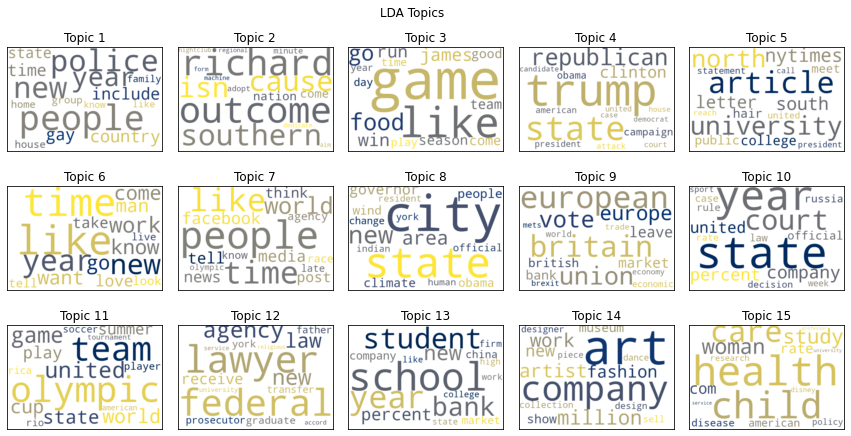

In [17]:
plot_wordclouds(topics)